<center>
<img src="http://image.yes24.com/goods/87039632/800x0" width="200" height="200"><br>
</center>


 - Github: [yoonkt200](https://github.com/yoonkt200/python-data-analysis)

# Chapter 03 미래를 예측하는 데이터 분석

#### 이 장의 핵심 개념
- 지도 학습과 비지도 학습의 개념을 이해한다.
- 회귀 분석으로 예측을 수행한다.
- 시계열 데이터의 트렌드를 예측한다.
- 수학적 기법을 활용하여 평점을 예측한다.

### 3-1 프로야구 선수의 다음 해 연봉 예측하기

### Step1 탐색: 프로야구 연봉 데이터 살펴보기

예제에서 살용할 연봉 데이터셋의 기본 정보를 살펴보자. 데이터의 기초 탐색결과는 다음과 같다. 프로야구 연봉 데이터셋은 총 152개이며, 22개 피처로 구성되어 있다. 이 22개의 피처는 선수가 가지고 있는 기록(승,패,홈런 등의 수치)들에 대한 세부 정보를 나타낸다.

- 프로야구 연봉 데이터셋의 기본 정보 구하기

In [349]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source: http://www.statiz.co.kr/

picher_file_path = './data/picher_stats_2017.csv'
batter_file_path = './data/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [350]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [351]:
print(picher.shape)

(152, 22)


이번 예제에서 예측할 회귀 분석의 목표(Y값)는 데이터 '연봉(2018)'피처 이다. 다음 코드는 이를 히스토 그램 상자 그림(Box Plot)으로 시각화 한 것이다.

- 예측할 대상인 '연봉'에 대한 정보

In [352]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot:>

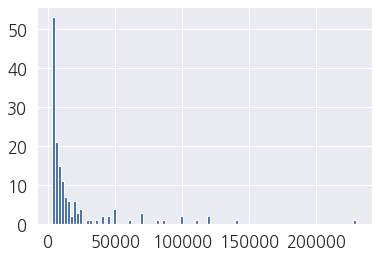

In [353]:
picher['연봉(2018)'].hist(bins=100) # 2018년 연봉 분포를 출력한다.

<AxesSubplot:>

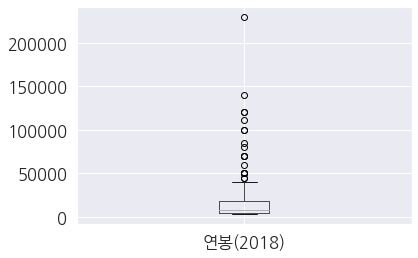

In [354]:
picher.boxplot(column=['연봉(2018)']) # 연봉의 상자 그림을 출력한다.

In [355]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


히스토그램에서는 연봉의 분포를 파악할 수 있으며, 상자 그림에서는 연봉의 일반적인 범주를 파악 할 수 있다. 흔히 말하는 '수십억대 연봉'을 받는 프로 선수는 별로 많지 않으며, 5억 원 미만의 연보잉 일반적으로 보인다. 다음으로 각각의 피처들은 어떤 특성을 가지고 있는지 살펴보자. 아래의 실행 결과는 '선수명'이나 '팀명'과 같이 그래프로 표현할 수 없는 피처들을 제외한 뒤, 모든 수치형 피처의 분포를 시각화한 것이다. 이를 통해 몇몇 피처들은 매우 불균형한 분포를 가지고 있다는 것을 알 수 있다.

- 회귀 분석에 사용할 피처 살펴보기

In [394]:
# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [18, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

In [395]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


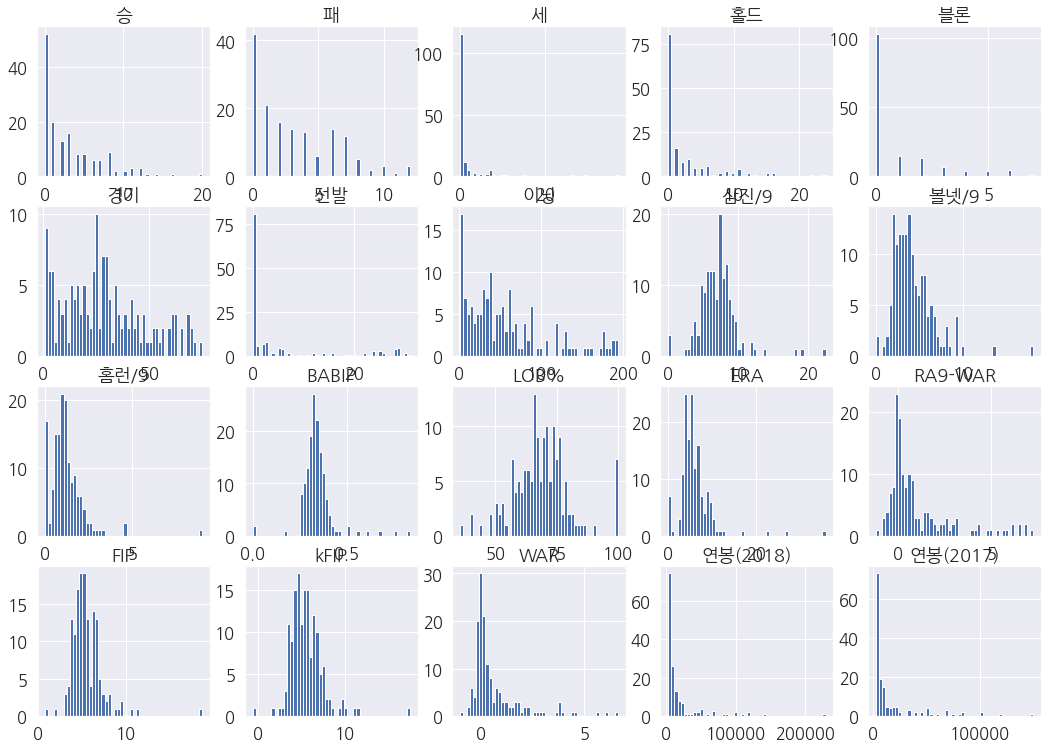

In [396]:
plot_hist_each_column(picher_features_df)

또 한 가지 그래프를 통해 알 수 있는 것은 각 피처 간의 단위가 다르다는 것이다. 예를 들어 '홈런/9'라는 피처는 x축이 0~8사이의 값인 반면, '이닝'이라는 피처는 0~200 사이의 값을 포함하고 있다. 이러한 데이터는 피처의 정규화 혹은 스케일링이 되어있지 않은 데이터 이다.

### Step2 예측: 투수의 연봉 예측하기

다음 코드에서는 여러 가지 피처 스케일링의 방법 중 표준화 방법을 적용하였다. 표준화는 정규분포에서 z-값을 구하는 과정과 동일하다. z-값은 ((X)-(X의평균) / X의 표준편차로 구한다.

- 피처들의 단위 맞춰주기 : 피처 스케일링

In [358]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해준다.
pd.options.mode.chained_assignment = None

In [359]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의한다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [360]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']
picher_df = standard_scaling(picher, scale_columns)

In [361]:
picher_df = picher_df.rename(columns={'연봉(2018)': 'y'})
picher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


연속형이 아닌 범주형 피처들은 어떻게 정규화 할 수 있을까요? 범주형 피처에는 **원-핫 인코딩**이라는 방법을 적용해야 한다. 판다스에서는 get_dummies()라는 함수로 간단하게 원-핫 인코딩을 적용 할 수 있다. 다음 실행 결과는 원-핫 인코딩의 적용 결과이다.

- 피처들의 단위 맞춰주기 : 원-핫 인코딩

In [362]:
# 팀명 피처를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [363]:
team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [364]:
picher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


이제 회귀 분석 모델을 학습시킬 준비가 거의 완료되었다. 한 가지 더 준비할 것은 모델의 **학습 데이터셋(학습 전용 데이터셋)과 모델의 테스트 데이터셋(테스트 전용 데이터셋)** 으로 데이터를 분리하는 것이다. 파이썬에서는 sklearn 이라는 train_test_split() 함수로 이를 수행할 수 있다. 다음 코드를 보자.

- 회귀 분석을 위한 학습, 테스트 데이터셋 분리

In [365]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리하기

X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=19)

이제 회귀 분석을 수행하는 코드를 살펴보았다. 다음 코드에서 sklearn 라이브러리의 LinearRegression()으로 모델 오브젝트를 선언한 뒤, 해당 오브젝트에 model=lr.fit(X_train, y_train) 코드를 실행시키자. 그러면 아래의 결과처럼 학습이 완료된 회귀식의 계수를 출력 할 수 있다.

- 회귀 분석 계수 학습 & 학습된 계수 출력

In [366]:
# 회귀 분석 계수를 학습한다. (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력한다.
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.55645139   5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


### Step 3 평가: 예측 모델 평가하기

회귀 분석은 statsmodel 라이브러리의 OLS 클래스로도 실행이 가능하다. OLS 클래스의 summary() 함수를 사용하면 다음의 실행 결과처럼 계수에 대한 자세한 분석 내용을 살펴볼 수 있다.

- 어떤 피처가 가장 영향력이 강한 피처 일까

In [367]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행한다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           7.70e-42
Time:                        16:00:22   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     3.59e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

위 실행 결과에서는 결정 계수(R-squared),혹은 수정 결정 계수(Adj, R-squared)라는 점수를 눈여겨볼 필요가 있다. 이 점수들은 회귀 분석이 얼마나 잘 되었는지 평가하는 지표이며, '회귀 분석으로 추정한 모델이 주어진 데이터를 얼마나 잘 설명하는가?'에 대한 점수이다. 이 점수들이 1에 가까울수록 데이터를 잘 설명하는 모델이다. 다음으로 F 통계량 (F-statistic)은 회귀식의 유의성 검정에 사용되는 값으로 P-value 인 Prob(F-statistc)수치와 함게 살펴봐야 한다. 일반적으로 P-value가 0.05 이하면 'F 통계량이 유의한 의미를 가진다' 라는 결론을 내려도 무방하며 이는 회귀 분석이 유의미한 결과를 가진다는 것이다. 또한 표의 P>t 라는 정보는 각 피처의 검정 통계량(t-statistics)이 얼마나 유의미한지에 대한 p-value를 나타낸는 것이다. 

- 어떤 피처가 가장 영향력이 강한 피처일까

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

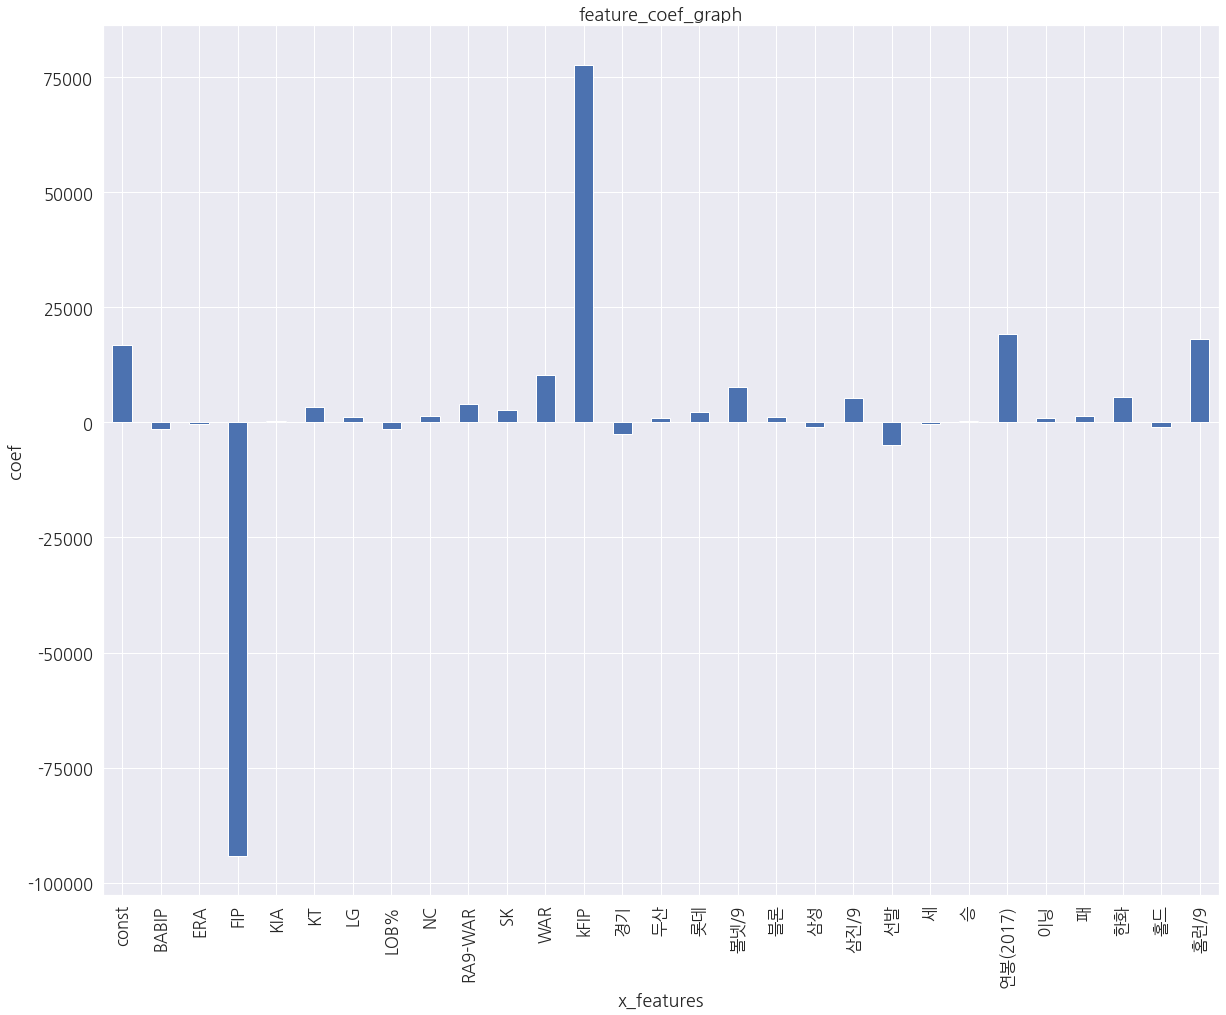

In [368]:
# 회귀 계수를 리스트로 반환한다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환 한다.
x_labels = model.params.index.tolist()

# 회귀 계수를 출력

ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

이에 대한 위 코드의 시각화 결과 FIP, WAR, 홈런, 작년 연봉 피처가 가장 영량력이 큰것으로 보인다. 다음으로 아래의 출력 결과는 수정 결정 계수(R2 score)를 sklean의 LineaarRegression 클래스로 출력해 보자.

 - 예측 모델의 평가하기 : R2 score

In [369]:
# 학습 데이터와 테스트 데이터로 분리한다.

X= picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 회귀 분석 모델을 학습하자
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 회귀 분석 모델을 평가한다.
print(model.score(X_train, y_train)) # train R2 score를 출력
print(model.score(X_test, y_test)) # test R2 score를 출력

0.9276949405576705
0.8860171644977815


실행 결과의 각 값은 학습 데이터셋과 테스트 데이터셋에 대한 평가 점수를 의미하며, 이 두 점수는 최대한 벌어지지 않는 것이 좋다. 만약 학습 점수가 테스트 점수에 비해 높다면 과적합이 발생한 것이다. 모의고사에만 특화된 공부를 한 나머지, 실제 시험의 새로운 유형에 적응하지 못하는 경우라고 비유할 수 있다. 회귀 모델을 평가할 때는 RMSE score라는 측정 지표를 활용할 수도 있다. 이 점수는 실제값과 예측값의 차이를 절대적인 수치로 나타낸 것이다. 이 값이 높으면 높을수록 예측이 부정확하다는 것의 의미한다. 다음 코드는 RMSE score를 출력한 것이다.

- 예측 모델의 평가하기 : RMSE score

In [370]:
# 회귀 분석 모델을 평가한다
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력

7282.718684746374
14310.69643688915


이번에는 피처들의 상관 관계를 살펴보기 위해 heatmap 방식의 시각화를 사용하겠다. 이를 통해 승-이닝, kFIP-FIP, RA9_WAR-WAR 등의 피처 쌍에서 높은 연관성을 발견할 수 있다.

- 피처들의 상관 관계 분석하기

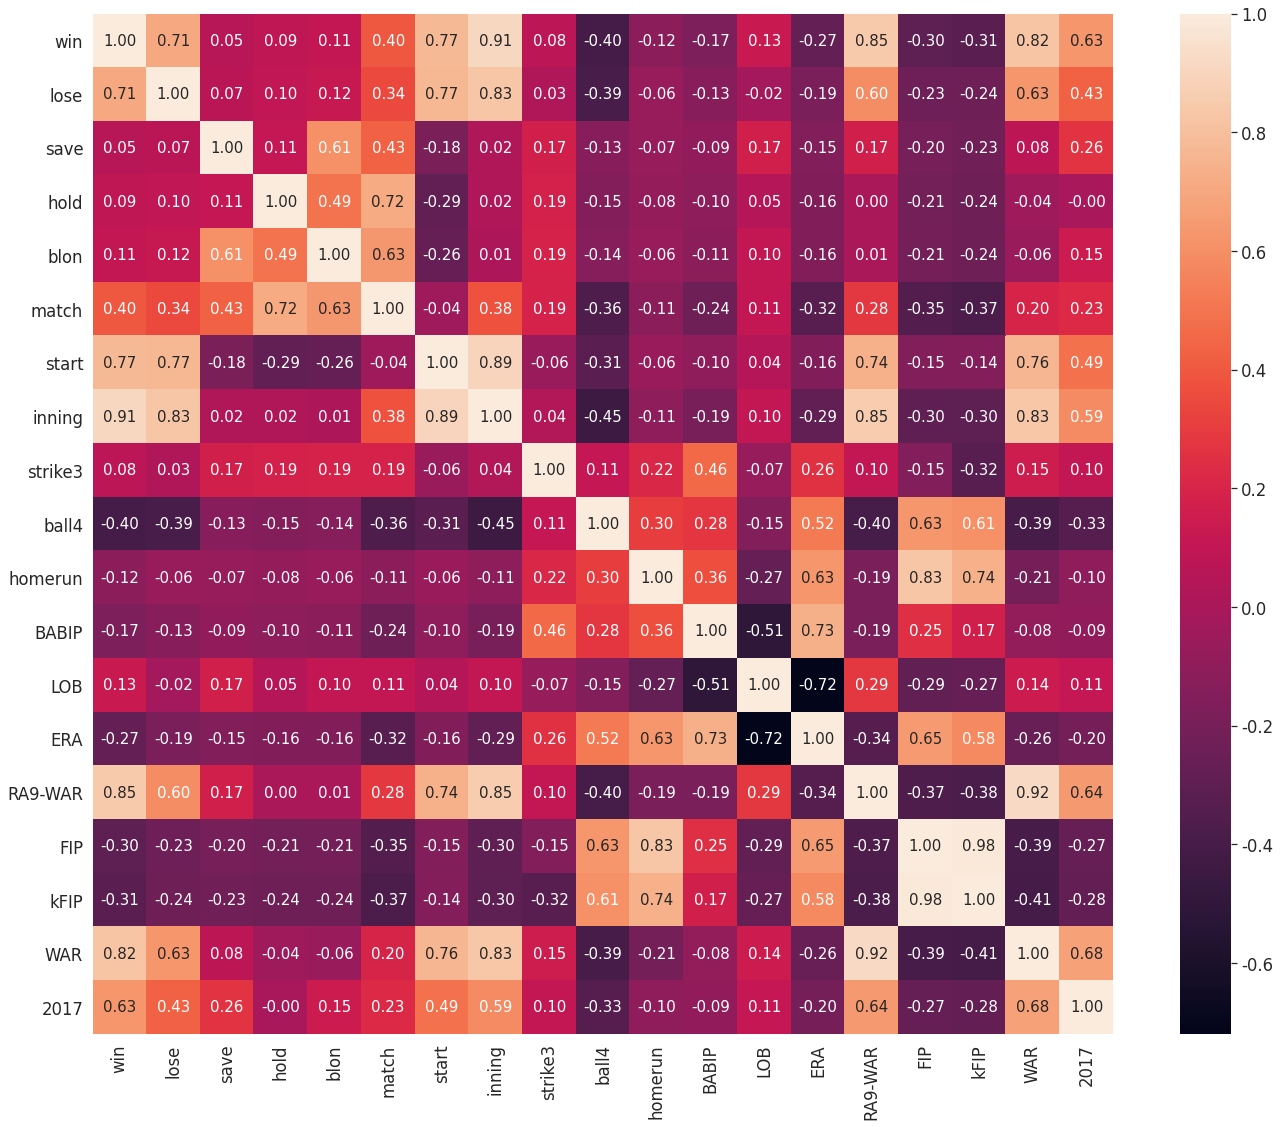

In [371]:
import seaborn as sns

# 피처간의 상관계수 행렬을 계산한다.
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# corr 행렬 히트맵을 시각화한다.
plt.rc('font', family='NanumGothicOTF')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

하지만 회귀 분석은 피처 간의 '독립성'을 전제로 하는 분석 방법이기 때문에 올바른 회귀 분석을 하려면 이러한 피처 쌍을 제거해야한다. 그래서 **다중 공선성** 이라는 것을 살펴봐야 한다. 두중 공선성이란 변수 간 상관 관계가 높아 분석에 부정적인 영향을 미치는 것을 의미한다. 다중 공선성을 살펴봄으로써 여러 피처 간의 연관성을 고려했을 때 어떤 피처를 제거하는 것이 옳은 판단일지 혹은 제거하는 것 자체가 맞는 판단인지에 대한 기준을 제시해줄 수 있다. 다중 공선성은 **분산팽창요인(VIF)Variance Inflation Factor** 이라는 계수로 평가할 수 있다. 일반적으로 VIF 계수가 10~15 정도를 넘으면 그 피처는 다중 공선성의 문제가 발생했다고 판단할수 있다.

- 회귀 분석 예측 성능을 높이기 위한 방법 : 다중 공선성 확인

In [372]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [373]:
# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


### `[미니 퀴즈 - 3.2]`
- `적절한 피처를 선정하여 다시 학습해보자
    - 사용할 피처를 다시 고른 뒤, 다시 학습을 진행했을 때의 Train score, Test score가 어떻게 향상되는지 살펴본다.
        - 저자의 경우 아래의 과정을 거쳐 ['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)'] 피처를 선정했을 때, 더욱 좋은 결과를 나타난다.
            - 선정 과정
                - 1. VIF 계수가 높은 피처들을 우선적으로 제거합니다. 단, (FIP, kFIP)와 같이 유사한 두가지 피처중에는 하나만을 제거한다.
                - 2. 다시 공선성을 검증합니다. 이전 단계에서는 VIF 계수가 높았던 볼넷, 삼진 등의 피처의 VIF 계수가 낮아진 것을 확인할 수 있습니다. VIF 계수가 비정상적으로 높은 피처를 제거해주면, 다른 피처들의 공선성도 자연스레 감소하기 때문이다.
                - 3. 여전히 VIF 계수가 높은 피처들을 제거한다.
                - 4. 남은 피처를 토대로 다시한번 회귀분석을 실시한다.. 분석 결과에서 p-value가 유의하면서도 영향력이 큰 피처들을 선정한다.
            - train_score, test_score를 비교했을 때, 기존보다 overfit이 비교적 덜 된것으로 보인다.
            - test rmse 역시 감소한 것을 볼 수 있다.

In [374]:
# 피처를 재선정합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [375]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [376]:
# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9150591192570362
0.9038759653889865


In [377]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7893.462873347693
13141.866063591084


In [378]:
# 피처마다의 VIF 계수를 출력합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


### Step4 시각화: 분석 결과 시각화하기

마지막 단계에서는 회귀 분석을 통해 얻어낸 예측연보과 2018년의 실제연봉 데이터를 비교하는 시각화 자료를 만들어보자. 다음의 코드는 회귀 분석 모델의 predict() 함수를 사용하여 2018년의 연봉을 예측하고, 이를 원래의 데이터 프레임에 '예측연봉'이라는 새로운 열로 합치는 과정이다. 전체 코드를 실행하면 [선수명, 실제연봉(2018), 예측연봉(2018), 작년연봉(2017)]을 columns로 하는 데이터 프레임을 출력할 수 있다. 단, 데이터 프레임을 생성할 때 한 가지 추가된 조건은 '재계약하여 연봉이 변화한 선수만을 대상으로 한다'는 조건이다. 재계약 하지 않은 선수는 연봉에 변화가 없으므로 예측의 의미가 없기 때문이다.

- 예측연봉과 실제연봉 비교하기

In [379]:
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
picher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)

In [380]:
# 원래의 데이터 프레임을 다시 로드
picher = pd.read_csv(picher_file_path)
picher = picher[['선수명', '연봉(2017)']]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합친다.
result_df = picher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(picher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


이에 대한 데이터 프레임의 시각화 결과는 아래와 같다. 그래프에서 볼 수 있듯이 학습한 회귀 모델은 연봉 상승의 전체적인 경향을 비죠적 잘 맞춰낸다. 피처가 몇개 되지 않는 간단한 회귀 분석이라는 것을 생각해보면 기대한 것보다는 정확한 예측 결과라고 할 수 있다.

In [382]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


<AxesSubplot:xlabel='선수명'>

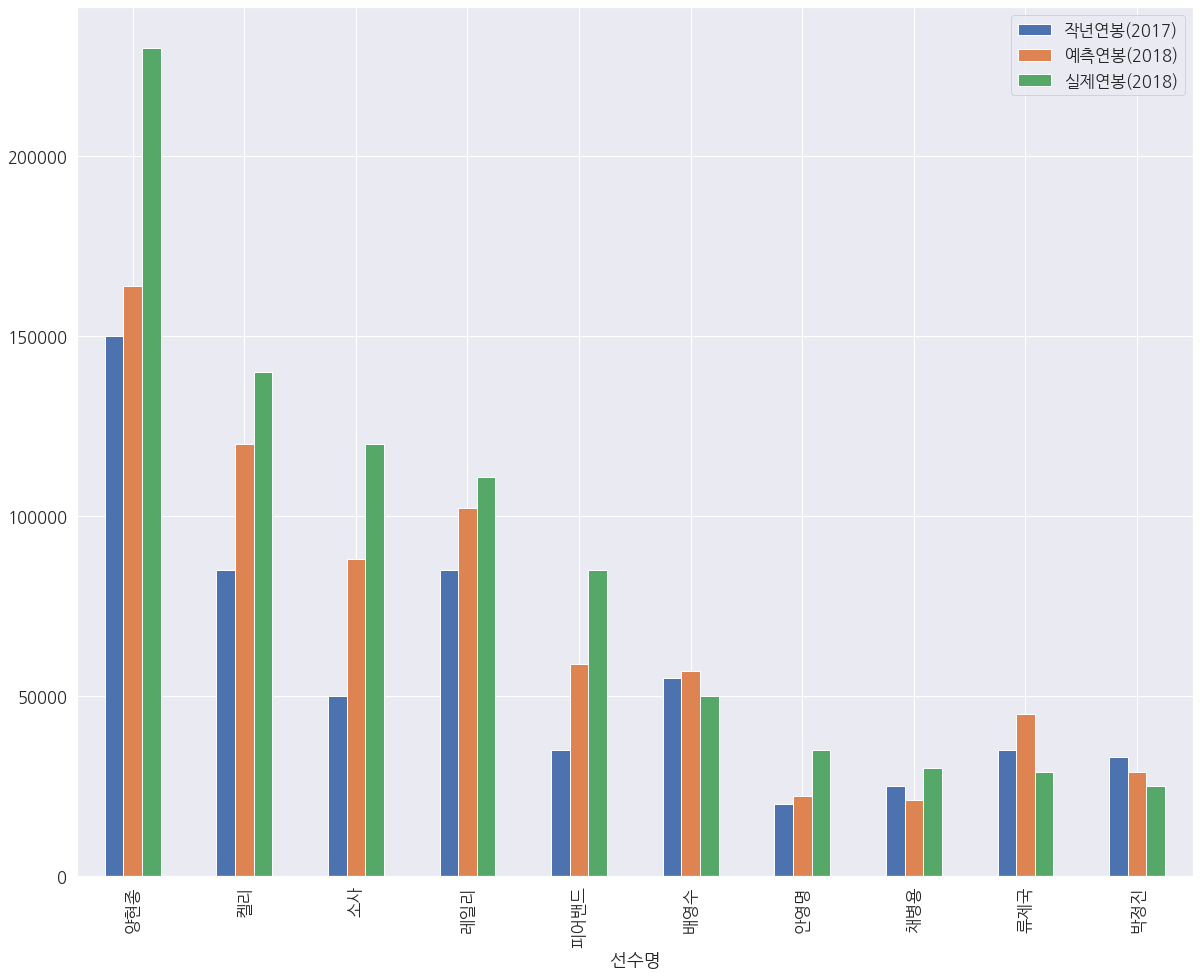

In [383]:
# 선수별 연봉 정보(작년연봉, 예측연봉, 실제연봉)를 막대 그래프로 출력한다.
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'],
              kind="bar")

지금까지 데이터 분석에서 가장 기초적인 예측 분석 방법인 회귀 분석을 알아보았다. 회귀 분석은 '머신러닝'을 비롯한 데이터 분석 기법 전반에 거려 아주 중요한 개념이기 때문에 중정적인 내용들을 반드시 이해하고 넘어가자.

- 출처: 이것이 데이터 분석이다 wiht 파이썬